# Imports 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
from torch import nn, optim 
from torch.utils.data import Dataset, DataLoader 

from torchvision import transforms as T

import timm

![](Untitled-design.png)

# Configurations

In [2]:
TRAIN_CSV = 'train.csv'
VALID_CSV = 'valid.csv'

BATCH_SIZE = 128
DEVICE = 'cpu'

MODEL_NAME = 'efficientnet_b0'

LR = 0.001
EPOCHS = 15

In [123]:
df_train = pd.read_csv(TRAIN_CSV)
df_valid = pd.read_csv(VALID_CSV)

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667,Squiggle
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490,Squiggle
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510,Squiggle
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373,Squiggle
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412,Squiggle


In [124]:
print(f"No. of examples present in df_train : {len(df_train)}")
print(f"No. of examples present in df_valid : {len(df_valid)}")
print(f"Labels are : {df_train['labels'].unique()}")

No. of examples present in df_train : 3200
No. of examples present in df_valid : 800
Labels are : ['Squiggle' 'Narrowbanddrd' 'Noises' 'Narrowband']


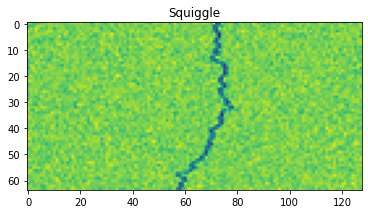

In [125]:
idx = 7

row = df_train.iloc[idx] 
image_pixels = np.array(row[0:8192], dtype=np.float64)
label = row.labels

image = np.resize(image_pixels, (64, 128))

plt.imshow(image)
plt.title(label);

# Declare Spec Augmentations 

![](image6.png)

In [126]:
from spec_augment import TimeMask, FreqMask

In [127]:
def get_train_transform():
    return T.Compose([
        TimeMask(T=15, num_masks=4),
        FreqMask(F=15, num_masks=3),
    ])

# Create Custom Dataset 

In [128]:
class SpecDataset(Dataset):
    
    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations
        
        label_mapper = {
            'Squiggle': 0,
            'Narrowband': 1,
            'Narrowbanddrd': 2,
            'Noises': 3,
        }
        
        self.df.loc[:, 'labels'] = self.df.labels.map(label_mapper)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_pixels = np.array(row[0:8192], dtype=np.float64)
        
        image = np.resize(image_pixels, (64, 128, 1))
        label = np.array(row.labels, dtype=np.float64)
        
        image = torch.Tensor(image).permute(2, 0, 1)
        label = torch.Tensor(label)
        
        if self.augmentations != None:
            image = self.augmentations(image)
            
        return image.float(), label.long()

In [129]:
trainset = SpecDataset(df_train, get_train_transform())
validset = SpecDataset(df_valid)

tensor(0)


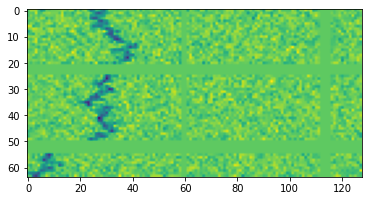

In [130]:
image, label = trainset[592]

plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

# Load dataset into Batches

In [131]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [132]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 25
Total no. of batches in validloader : 7


In [133]:
for images, labels in trainloader:
    break

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([128, 1, 64, 128])
One label batch shape : torch.Size([128])


# Load Model

In [134]:
class SpecModel(nn.Module):
    
    def __init__(self):
        super(SpecModel, self).__init__()
        
        self.net = timm.create_model(MODEL_NAME, num_classes=4, pretrained=True, in_chans=1)
        
    def forward(self, images, labels=None):
        logits = self.net(images)
        
        if labels != None:
            loss = nn.CrossEntropyLoss()
            return logits, loss(logits, labels)
        return logits

In [135]:
model = SpecModel()
model

SpecModel(
  (net): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

# Create Train and Eval Function

In [136]:
from tqdm.notebook import tqdm 
from utils import multiclass_accuracy

In [137]:
def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epoch + 1) + '/' + str(EPOCHS))
    
    for t, data in enumerate(progress_bar):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        
        temp = {'loss': '%6f' %float(total_loss / (t + 1)), 'acc': '%6f' %float(total_acc / (t + 1))}
        
        progress_bar.set_postfix(temp)
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [138]:
def eval_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epoch + 1) + '/' + str(EPOCHS))
    
    with torch.no_grad():
        for t, data in enumerate(progress_bar):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            logits, loss = model(images, labels)

            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)

            temp = {'loss': '%6f' %float(total_loss / (t + 1)), 'acc': '%6f' %float(total_acc / (t + 1))}

            progress_bar.set_postfix(temp)
    return total_loss / len(dataloader), total_acc / len(dataloader)

# Training Loop 

In [139]:
def fit(model, trainloader, validloader, optimizer):
    best_valid_loss = np.Inf
    
    for i in range(EPOCHS):
        train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
        valid_loss, valid_acc = eval_fn(model, validloader, i)
        
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), MODEL_NAME + '-best-weights.pt')
            best_valid_loss = valid_loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
fit(model, trainloader, validloader, optimizer)

EPOCH[TRAIN]1/15:   0%|          | 0/25 [00:00<?, ?it/s]

# Inference 

In [ ]:
from utils import view_classify